In [2]:
import os
import sys
AeroBDSM_OOP_dir = os.path.abspath(os.path.join('../..'))
if AeroBDSM_OOP_dir not in sys.path:
    sys.path.append(AeroBDSM_OOP_dir)

from fuselage import *
from libs.Atmosphere import atmo
from math import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Геометрические параметры фюзеляжа

In [3]:
# Геометрические параметры фюзеляжа

D = 0.31
L_main = 4.2
L_nos = 0.37
L_cor = 0.115   # длина кормы уменьшена до 0,1 из-за того, что крылья заходят на корму
D_dn = 0.27
r_sph = 0.0775    # 0.5 * D / 2
D_a = 0.9 * D_dn
h_s = 0e-5              # относительная высота бугорков поверхности фюзеляжа

xx_0 = 0.529            # относительная координата центра вращения в долях длины фюзеляжа (от носа) относительно которой считаются моменты
x_t = None              # относительная координата перехода пограничного слоя из ламинарного в турбулентный в долях длины фюзеляжа
T_s = None              # средняя температура поверхности фюзеляжа, К
is_active = False       # активный или пассивный (режим работы сопла на донном срезе)

S_m = pi * D**2 / 4
lambda_nos = L_nos / D
lambda_cor = L_cor / D
lambda_cil = (L_main - L_cor - L_nos) / D
eta_cor = D_dn / D
x_0 = xx_0 * L_main

print(f'''{D = }\n{L_main = }\n{L_cor = }\n{D_dn = }\n{r_sph = }\n{D_a = }\n{x_0 = }\n{lambda_nos = }\n{lambda_cor = }\n{lambda_cil = }\n{eta_cor = }''')

D = 0.31
L_main = 4.2
L_cor = 0.115
D_dn = 0.27
r_sph = 0.0775
D_a = 0.24300000000000002
x_0 = 2.2218
lambda_nos = 1.1935483870967742
lambda_cor = 0.3709677419354839
lambda_cil = 11.983870967741936
eta_cor = 0.870967741935484


## Создаём объект фюзеляжа

In [4]:
nc = NosCil_SphOgi(
    lambd_nos=lambda_nos,
    lambd_cil=lambda_cil,
    D=D,
    r_sph=r_sph,    
    )
nc1 = NosCil_Ell(
    lambd_nos=lambda_nos,
    lambd_cil=lambda_cil,
    D=D    
)
cor = Cor_Con(
    D=D,
    eta_cor=eta_cor,
    lambd_cor=lambda_cor,
    D_a=D_a)
cor1 = Cor_Non(D = D, D_a = D_a)
fuselag = Fuselage(
    nosCil=nc1,
    cor=cor,
    h_s = h_s)


In [5]:
def c_x(X, q, S):
    return X / q / S

def c_y(Y, q, S):
    return Y / q / S

def c_y_to_c_ya(alpha, cy, cx):
    return cy * np.cos(np.deg2rad(alpha)) - cx * np.sin(np.deg2rad(alpha))

def c_x_to_c_xa(alpha, cy, cx):
    return cy * np.sin(np.deg2rad(alpha)) + cx * np.cos(np.deg2rad(alpha))

## Обработка результатов, полученных в Ansys

In [6]:
# Результаты расчета в Ansys

alpha_fus_Ansys = np.array([0.001, 2, 5, 10, 15, 20])

Y_M06_fus_Ansys = np.array([1.28874, 148.79, 360.42, 870.47, 1616.87, 2594.6])
X_M06_fus_Ansys = np.array([366.6, 398.92, 454.1, 532.23, 556.87, 526.86])
Mz_M06_fus_Ansys = np.array([13.8326, 65.74, 92.89, 566.91, 1552.49, 2923.9])

Y_M08_fus_Ansys = np.array([2.5066, 238.82, 617.692, 1548.474, 2963.596, 4859.022])
X_M08_fus_Ansys = np.array([670.8, 716, 807.144, 833.838, 955.354, 921.81])
Mz_M08_fus_Ansys = np.array([23.552, 2.574, 34.424, 866.078, 2757.288, 5496.49])

Y_M11_fus_Ansys = np.array([- 1.52, 678.578, 1719.226, 4035.958, 7432.048, 12819.4705])
X_M11_fus_Ansys = np.array([3830.21, 3857.899, 4012.557, 4310.7, 4458.331, 4421.397])
Mz_M11_fus_Ansys = np.array([- 2.472, 471.448, 1312.175, 4035.958, 8419.503, 15505.176])

Y_M15_fus_Ansys = np.array([- 1.92246, 1230.449, 3276.596, 8309.391, 17268.788, 34342])
X_M15_fus_Ansys = np.array([7407.6, 7825.962, 8337.843, 8677.041, 9025.452, 9149])
Mz_M15_fus_Ansys = np.array([0, 547.268, 1961.79, 7892.807, 19522.909, 44136])

Y_M2_fus_Ansys = np.array([24.084, 2225.4, 5869.768, 15564.738, 48982.827, 75733.538])
X_M2_fus_Ansys = np.array([12891.6, 13063.8, 13646.816, 14525.614, 15110.011, 14940.247])
Mz_M2_fus_Ansys = np.array([- 3.0354, 722.43, 2692.4, 13564.099, 67986.0, 124270.614])
# Y_M2_fus_Ansys = 2 * np.array([16.35, 1100.21, 3232.55, 8906.16, 19969.988, 37991.91])    #1
# X_M2_fus_Ansys = 2 * np.array([5787.81, 5870.88, 6194.63, 6726.57, 7073.0659, 7165.677])  #1


# Высота полета
H_Ansys = 100
rho_Ansys = atmo.rho(H_Ansys)
a_Ansys = atmo.a(H_Ansys)

# Параметры невозмущенного потока
M06 = 0.6
M08 = 0.8
M11 = 1.1
M15 = 1.5
M2 = 2

V06 = M06*a_Ansys
V08 = M08*a_Ansys
V11 = M11*a_Ansys
V15 = M15*a_Ansys
V2 = M2*a_Ansys

q_M06 = rho_Ansys * V06 ** 2 / 2
q_M08 = rho_Ansys * V08 ** 2 / 2
q_M11 = rho_Ansys * V11 ** 2 / 2
q_M15 = rho_Ansys * V15 ** 2 / 2
q_M2 = rho_Ansys * V2 ** 2 / 2

# Коэффициенты сил в связанной системе координат
cy_M06_fus_Ansys = c_y(Y_M06_fus_Ansys, q_M06, S_m)
cy_M08_fus_Ansys = c_y(Y_M08_fus_Ansys, q_M08, S_m)
cy_M11_fus_Ansys = c_y(Y_M11_fus_Ansys, q_M11, S_m)
cy_M15_fus_Ansys = c_y(Y_M15_fus_Ansys, q_M15, S_m)
cy_M2_fus_Ansys = c_y(Y_M2_fus_Ansys, q_M2, S_m)

cx_M06_fus_Ansys = c_x(X_M06_fus_Ansys, q_M06, S_m)
cx_M08_fus_Ansys = c_x(X_M08_fus_Ansys, q_M08, S_m)
cx_M11_fus_Ansys = c_x(X_M11_fus_Ansys, q_M11, S_m)
cx_M15_fus_Ansys = c_x(X_M15_fus_Ansys, q_M15, S_m)
cx_M2_fus_Ansys = c_x(X_M2_fus_Ansys, q_M2, S_m)


# Коэффициенты сил в скоростной системе координат
cya_M06_fus_Ansys = c_y_to_c_ya(alpha_fus_Ansys, cy_M06_fus_Ansys, cx_M06_fus_Ansys)
cya_M08_fus_Ansys = c_y_to_c_ya(alpha_fus_Ansys, cy_M08_fus_Ansys, cx_M08_fus_Ansys)
cya_M11_fus_Ansys = c_y_to_c_ya(alpha_fus_Ansys, cy_M11_fus_Ansys, cx_M11_fus_Ansys)
cya_M15_fus_Ansys = c_y_to_c_ya(alpha_fus_Ansys, cy_M15_fus_Ansys, cx_M15_fus_Ansys)
cya_M2_fus_Ansys = c_y_to_c_ya(alpha_fus_Ansys, cy_M2_fus_Ansys, cx_M2_fus_Ansys)

cxa_M06_fus_Ansys = c_x_to_c_xa(alpha_fus_Ansys, cy_M06_fus_Ansys, cx_M06_fus_Ansys)
cxa_M08_fus_Ansys = c_x_to_c_xa(alpha_fus_Ansys, cy_M08_fus_Ansys, cx_M08_fus_Ansys)
cxa_M11_fus_Ansys = c_x_to_c_xa(alpha_fus_Ansys, cy_M11_fus_Ansys, cx_M11_fus_Ansys)
cxa_M15_fus_Ansys = c_x_to_c_xa(alpha_fus_Ansys, cy_M15_fus_Ansys, cx_M15_fus_Ansys)
cxa_M2_fus_Ansys = c_x_to_c_xa(alpha_fus_Ansys, cy_M2_fus_Ansys, cx_M2_fus_Ansys)

In [7]:
c_y_don = cor.coef_c_x_dn(0.8001, False)
print(c_y_don)
print(0.6607028997651497)

0.6605066206775273
0.6607028997651497


## Запись и обработка результатов, полученных в ООП

In [8]:
alpha_fus_LiCH = np.array([0.0, 0.1, 0.5 , 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

cy_M06_fus_LiH = []
cy_M08_fus_LiH = []
cy_M11_fus_LiH = []
cy_M15_fus_LiH = []
cy_M2_fus_LiH = []

cx_M06_fus_LiH = []
cx_M08_fus_LiH = []
cx_M11_fus_LiH = []
cx_M15_fus_LiH = []
cx_M2_fus_LiH = []

cya_M06_fus_LiH = []
cya_M08_fus_LiH = []
cya_M11_fus_LiH = []
cya_M15_fus_LiH = []
cya_M2_fus_LiH = []

cxa_M06_fus_LiH = []
cxa_M08_fus_LiH = []
cxa_M11_fus_LiH = []
cxa_M15_fus_LiH = []
cxa_M2_fus_LiH = []

xd_M06_fus_LiH = []
xd_M08_fus_LiH = []
xd_M11_fus_LiH = []
xd_M15_fus_LiH = []
xd_M2_fus_LiH = []

# Число Маха = 0.6
for alf in alpha_fus_LiCH:
    c_y = fuselag.c_y(M06, np.deg2rad(alf))
    c_ya = fuselag.c_ya(M06, np.deg2rad(alf), H_Ansys, is_active, x_t, T_s)
    c_x = fuselag.c_x(M06, np.deg2rad(alf), H_Ansys, is_active, x_t, T_s)
    c_xa = fuselag.c_xa(M06, np.deg2rad(alf), H_Ansys, is_active, x_t, T_s)
    x_d = fuselag.x_d(M06, np.deg2rad(alf))    
    cy_M06_fus_LiH.append(c_y)
    cya_M06_fus_LiH.append(c_ya)
    cx_M06_fus_LiH.append(c_x)
    cxa_M06_fus_LiH.append(c_xa)
    xd_M06_fus_LiH.append(x_d)

# Число Маха = 0.8
for alf in alpha_fus_LiCH:
    c_y = fuselag.c_y(M08, np.deg2rad(alf))
    c_ya = fuselag.c_ya(M08, np.deg2rad(alf), H_Ansys, is_active, x_t, T_s)
    c_x = fuselag.c_x(M08, np.deg2rad(alf), H_Ansys, is_active, x_t, T_s)
    c_xa = fuselag.c_xa(M08, np.deg2rad(alf), H_Ansys, is_active, x_t, T_s)
    x_d = fuselag.x_d(M08, np.deg2rad(alf))    
    cy_M08_fus_LiH.append(c_y)
    cya_M08_fus_LiH.append(c_ya)
    cx_M08_fus_LiH.append(c_x)
    cxa_M08_fus_LiH.append(c_xa)
    xd_M08_fus_LiH.append(x_d)

# Число Маха = 1.1
for alf in alpha_fus_LiCH:
    c_y = fuselag.c_y(M11, np.deg2rad(alf))
    c_ya = fuselag.c_ya(M11, np.deg2rad(alf), H_Ansys, is_active, x_t, T_s)
    c_x = fuselag.c_x(M11, np.deg2rad(alf), H_Ansys, is_active, x_t, T_s)
    c_xa = fuselag.c_xa(M11, np.deg2rad(alf), H_Ansys, is_active, x_t, T_s)
    x_d = fuselag.x_d(M11, np.deg2rad(alf))    
    cy_M11_fus_LiH.append(c_y)
    cya_M11_fus_LiH.append(c_ya)
    cx_M11_fus_LiH.append(c_x)
    cxa_M11_fus_LiH.append(c_xa)
    xd_M11_fus_LiH.append(x_d)

# Число Маха = 1.5
for alf in alpha_fus_LiCH:
    c_y = fuselag.c_y(M15, np.deg2rad(alf))
    c_ya = fuselag.c_ya(M15, np.deg2rad(alf), H_Ansys, is_active, x_t, T_s)
    c_x = fuselag.c_x(M15, np.deg2rad(alf), H_Ansys, is_active, x_t, T_s)
    c_xa = fuselag.c_xa(M15, np.deg2rad(alf), H_Ansys, is_active, x_t, T_s)
    x_d = fuselag.x_d(M15, np.deg2rad(alf))    
    cy_M15_fus_LiH.append(c_y)
    cya_M15_fus_LiH.append(c_ya)
    cx_M15_fus_LiH.append(c_x)
    cxa_M15_fus_LiH.append(c_xa)
    xd_M15_fus_LiH.append(x_d)

# Число Маха = 2
for alf in alpha_fus_LiCH:
    c_y = fuselag.c_y(M2, np.deg2rad(alf))
    c_ya = fuselag.c_ya(M2, np.deg2rad(alf), H_Ansys, is_active, x_t, T_s)
    c_x = fuselag.c_x(M2, np.deg2rad(alf), H_Ansys, is_active, x_t, T_s)
    c_xa = fuselag.c_xa(M2, np.deg2rad(alf), H_Ansys, is_active, x_t, T_s)
    x_d = fuselag.x_d(M2, np.deg2rad(alf))    
    cy_M2_fus_LiH.append(c_y)
    cya_M2_fus_LiH.append(c_ya)
    cx_M2_fus_LiH.append(c_x)
    cxa_M2_fus_LiH.append(c_xa)
    xd_M2_fus_LiH.append(x_d)

## Графики Cy для различных чисел Маха

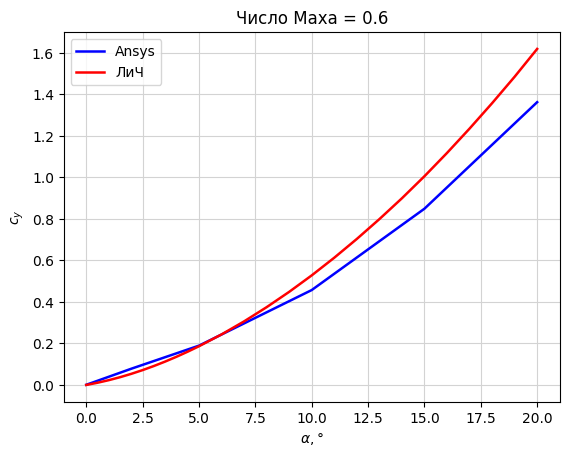

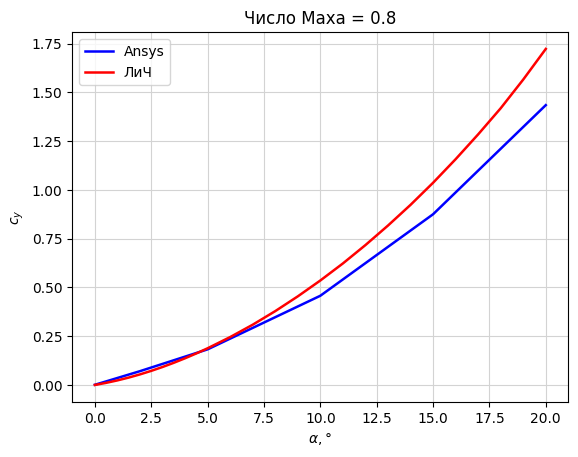

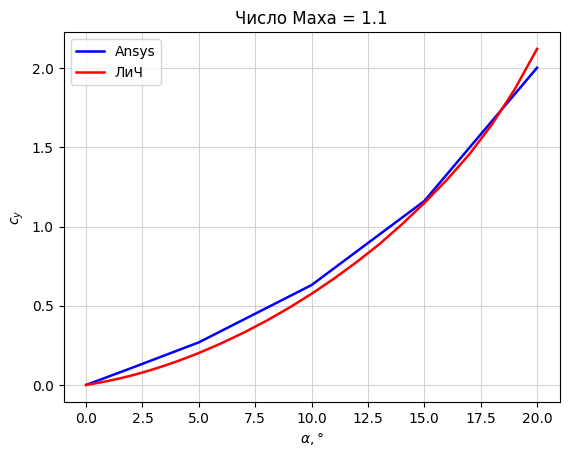

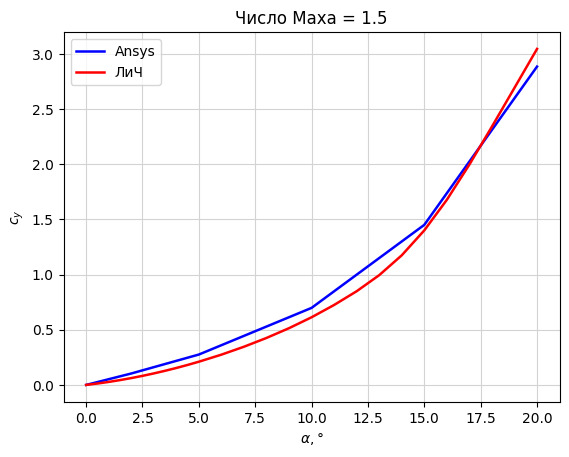

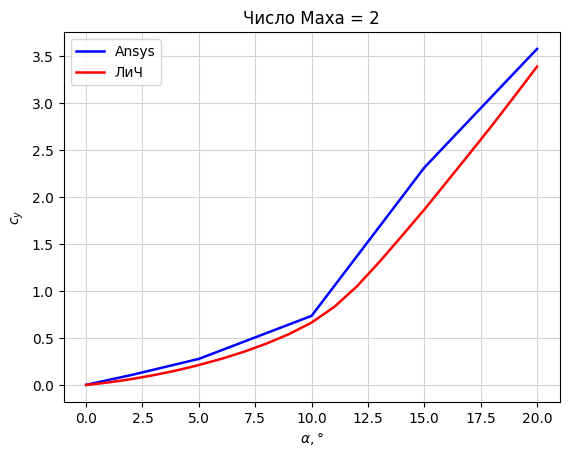

In [9]:
plt.title('Число Маха = 0.6')
plt.plot(alpha_fus_Ansys, cy_M06_fus_Ansys, color = 'blue', lw = 1.8, label = 'Ansys')
plt.plot(alpha_fus_LiCH, cy_M06_fus_LiH, color = 'red', lw = 1.8, label = 'ЛиЧ')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{y}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('fuselage_plots\M06 c_y.jpeg')
plt.show()

plt.title('Число Маха = 0.8')
plt.plot(alpha_fus_Ansys, cy_M08_fus_Ansys, color = 'blue', lw = 1.8, label = 'Ansys')
plt.plot(alpha_fus_LiCH, cy_M08_fus_LiH, color = 'red', lw = 1.8, label = 'ЛиЧ')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{y}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('fuselage_plots\M08 c_y.jpeg')
plt.show()

plt.title('Число Маха = 1.1')
plt.plot(alpha_fus_Ansys, cy_M11_fus_Ansys, color = 'blue', lw = 1.8, label = 'Ansys')
plt.plot(alpha_fus_LiCH, cy_M11_fus_LiH, color = 'red', lw = 1.8, label = 'ЛиЧ')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{y}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('fuselage_plots\M11 c_y.jpeg')
plt.show()

plt.title('Число Маха = 1.5')
plt.plot(alpha_fus_Ansys, cy_M15_fus_Ansys, color = 'blue', lw = 1.8, label = 'Ansys')
plt.plot(alpha_fus_LiCH, cy_M15_fus_LiH, color = 'red', lw = 1.8, label = 'ЛиЧ')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{y}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('fuselage_plots\M15 c_y.jpeg')
plt.show()

plt.title('Число Маха = 2')
plt.plot(alpha_fus_Ansys, cy_M2_fus_Ansys, color = 'blue', lw = 1.8, label = 'Ansys')
plt.plot(alpha_fus_LiCH, cy_M2_fus_LiH, color = 'red', lw = 1.8, label = 'ЛиЧ')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{y}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('fuselage_plots\M2 c_y.jpeg')
plt.show()

## Графики Cya для различных чисел Маха

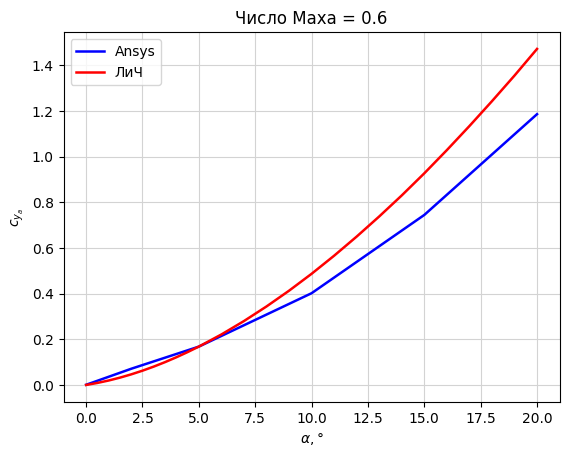

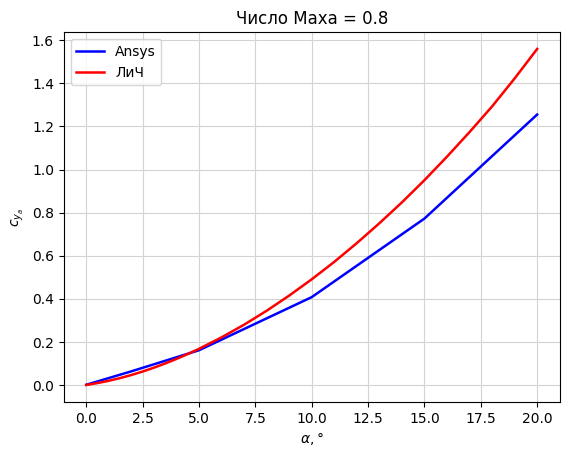

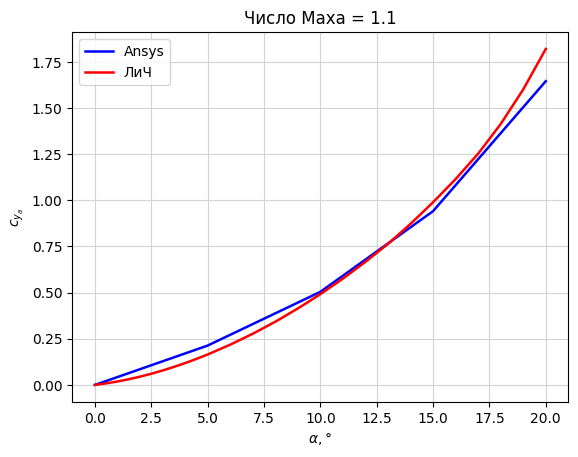

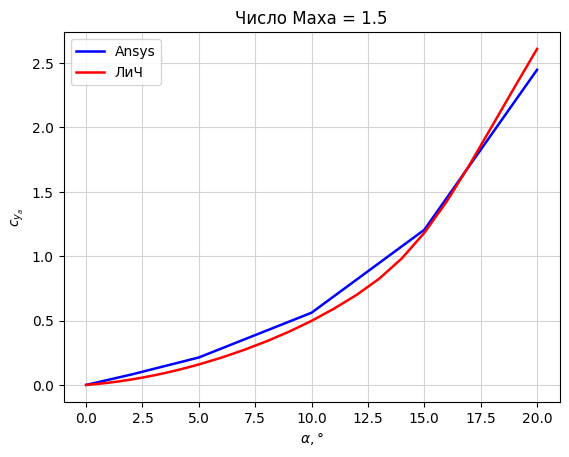

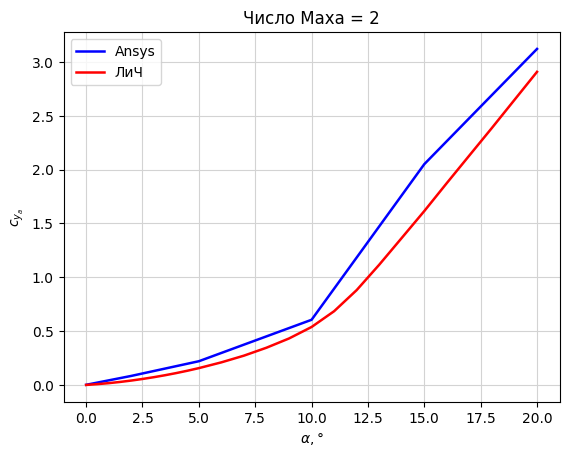

In [10]:
plt.title('Число Маха = 0.6')
plt.plot(alpha_fus_Ansys, cya_M06_fus_Ansys, color = 'blue', lw = 1.8, label = 'Ansys')
plt.plot(alpha_fus_LiCH, cya_M06_fus_LiH, color = 'red', lw = 1.8, label = 'ЛиЧ')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{y_a}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('fuselage_plots\M06 c_ya.jpeg')
plt.show()

plt.title('Число Маха = 0.8')
plt.plot(alpha_fus_Ansys, cya_M08_fus_Ansys, color = 'blue', lw = 1.8, label = 'Ansys')
plt.plot(alpha_fus_LiCH, cya_M08_fus_LiH, color = 'red', lw = 1.8, label = 'ЛиЧ')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{y_a}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('fuselage_plots\M08 c_ya.jpeg')
plt.show()

plt.title('Число Маха = 1.1')
plt.plot(alpha_fus_Ansys, cya_M11_fus_Ansys, color = 'blue', lw = 1.8, label = 'Ansys')
plt.plot(alpha_fus_LiCH, cya_M11_fus_LiH, color = 'red', lw = 1.8, label = 'ЛиЧ')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{y_a}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('fuselage_plots\M11 c_ya.jpeg')
plt.show()

plt.title('Число Маха = 1.5')
plt.plot(alpha_fus_Ansys, cya_M15_fus_Ansys, color = 'blue', lw = 1.8, label = 'Ansys')
plt.plot(alpha_fus_LiCH, cya_M15_fus_LiH, color = 'red', lw = 1.8, label = 'ЛиЧ')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{y_a}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('fuselage_plots\M15 c_ya.jpeg')
plt.show()

plt.title('Число Маха = 2')
plt.plot(alpha_fus_Ansys, cya_M2_fus_Ansys, color = 'blue', lw = 1.8, label = 'Ansys')
plt.plot(alpha_fus_LiCH, cya_M2_fus_LiH, color = 'red', lw = 1.8, label = 'ЛиЧ')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{y_a}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('fuselage_plots\M2 c_ya.jpeg')
plt.show()

## Графики Cx для различных чисел Маха

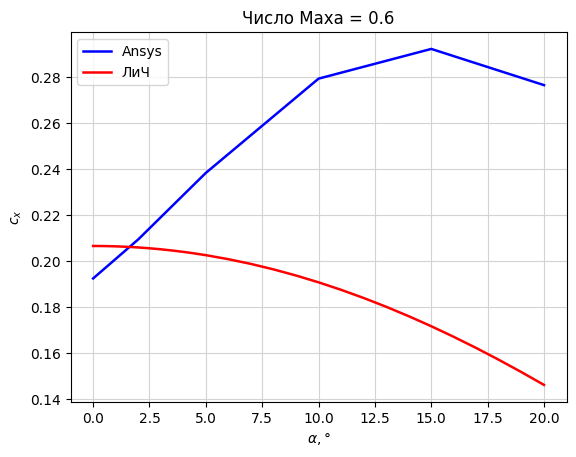

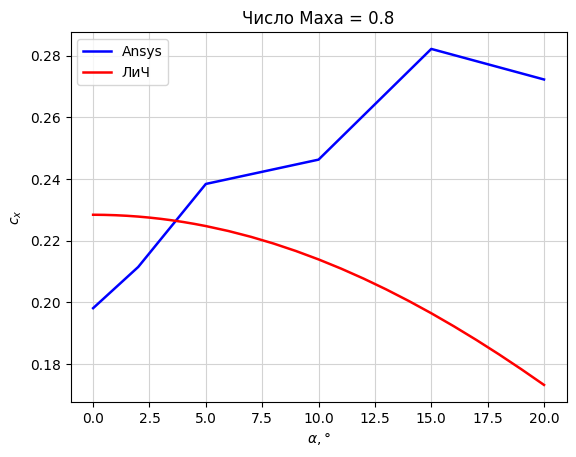

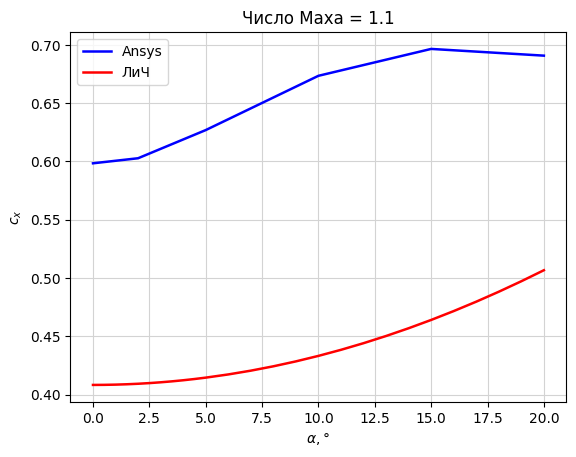

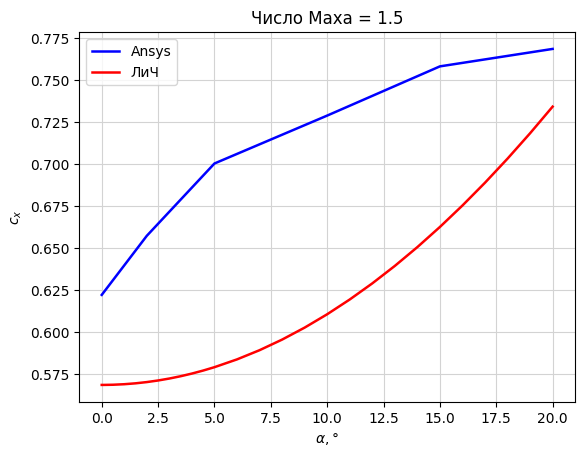

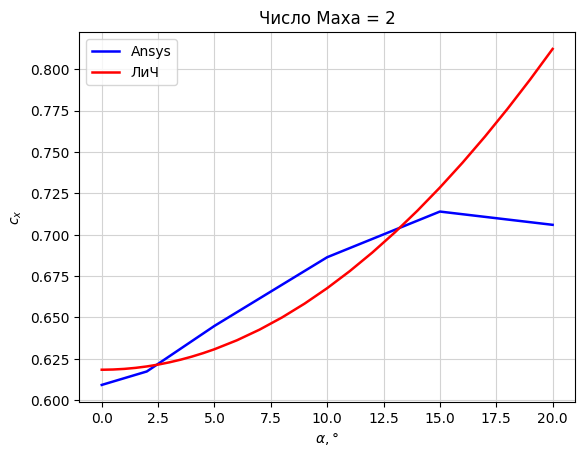

In [11]:
plt.title('Число Маха = 0.6')
plt.plot(alpha_fus_Ansys, cx_M06_fus_Ansys, color = 'blue', lw = 1.8, label = 'Ansys')
plt.plot(alpha_fus_LiCH, cx_M06_fus_LiH, color = 'red', lw = 1.8, label = 'ЛиЧ')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{x}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('fuselage_plots\M06 c_x.jpeg')
plt.show()

plt.title('Число Маха = 0.8')
plt.plot(alpha_fus_Ansys, cx_M08_fus_Ansys, color = 'blue', lw = 1.8, label = 'Ansys')
plt.plot(alpha_fus_LiCH, cx_M08_fus_LiH, color = 'red', lw = 1.8, label = 'ЛиЧ')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{x}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('fuselage_plots\M08 c_x.jpeg')
plt.show()

plt.title('Число Маха = 1.1')
plt.plot(alpha_fus_Ansys, cx_M11_fus_Ansys, color = 'blue', lw = 1.8, label = 'Ansys')
plt.plot(alpha_fus_LiCH, cx_M11_fus_LiH, color = 'red', lw = 1.8, label = 'ЛиЧ')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{x}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('fuselage_plots\M11 c_x.jpeg')
plt.show()

plt.title('Число Маха = 1.5')
plt.plot(alpha_fus_Ansys, cx_M15_fus_Ansys, color = 'blue', lw = 1.8, label = 'Ansys')
plt.plot(alpha_fus_LiCH, cx_M15_fus_LiH, color = 'red', lw = 1.8, label = 'ЛиЧ')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{x}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('fuselage_plots\M15 c_x.jpeg')
plt.show()

plt.title('Число Маха = 2')
plt.plot(alpha_fus_Ansys, cx_M2_fus_Ansys, color = 'blue', lw = 1.8, label = 'Ansys')
plt.plot(alpha_fus_LiCH, cx_M2_fus_LiH, color = 'red', lw = 1.8, label = 'ЛиЧ')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{x}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('fuselage_plots\M2 c_x.jpeg')
plt.show()

## Графики Cxa для различных чисел Маха

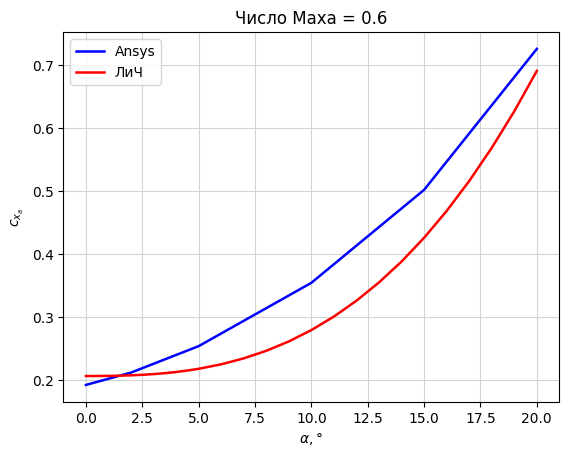

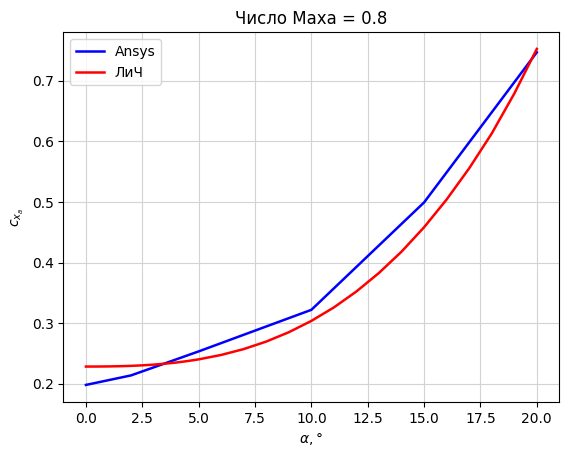

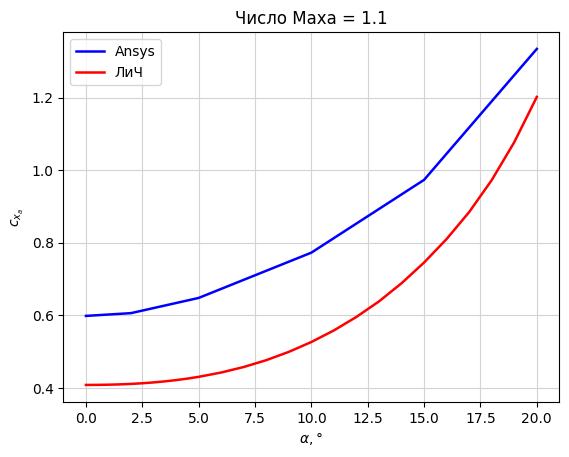

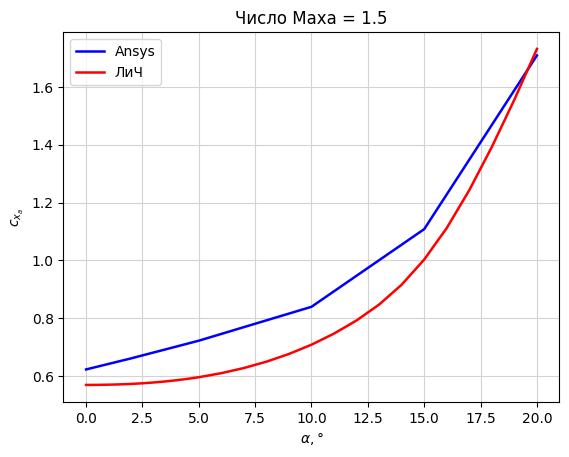

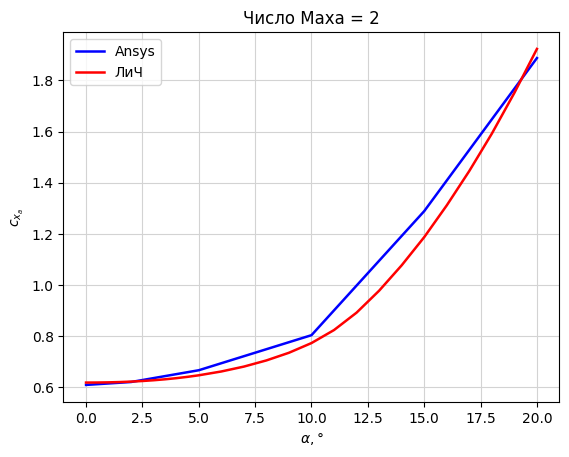

In [12]:
plt.title('Число Маха = 0.6')
plt.plot(alpha_fus_Ansys, cxa_M06_fus_Ansys, color = 'blue', lw = 1.8, label = 'Ansys')
plt.plot(alpha_fus_LiCH, cxa_M06_fus_LiH, color = 'red', lw = 1.8, label = 'ЛиЧ')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{x_a}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('fuselage_plots\M06 c_xa.jpeg')
plt.show()

plt.title('Число Маха = 0.8')
plt.plot(alpha_fus_Ansys, cxa_M08_fus_Ansys, color = 'blue', lw = 1.8, label = 'Ansys')
plt.plot(alpha_fus_LiCH, cxa_M08_fus_LiH, color = 'red', lw = 1.8, label = 'ЛиЧ')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{x_a}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('fuselage_plots\M08 c_xa.jpeg')
plt.show()

plt.title('Число Маха = 1.1')
plt.plot(alpha_fus_Ansys, cxa_M11_fus_Ansys, color = 'blue', lw = 1.8, label = 'Ansys')
plt.plot(alpha_fus_LiCH, cxa_M11_fus_LiH, color = 'red', lw = 1.8, label = 'ЛиЧ')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{x_a}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('fuselage_plots\M11 c_xa.jpeg')
plt.show()

plt.title('Число Маха = 1.5')
plt.plot(alpha_fus_Ansys, cxa_M15_fus_Ansys, color = 'blue', lw = 1.8, label = 'Ansys')
plt.plot(alpha_fus_LiCH, cxa_M15_fus_LiH, color = 'red', lw = 1.8, label = 'ЛиЧ')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{x_a}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('fuselage_plots\M15 c_xa.jpeg')
plt.show()

plt.title('Число Маха = 2')
plt.plot(alpha_fus_Ansys, cxa_M2_fus_Ansys, color = 'blue', lw = 1.8, label = 'Ansys')
plt.plot(alpha_fus_LiCH, cxa_M2_fus_LiH, color = 'red', lw = 1.8, label = 'ЛиЧ')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{x_a}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('fuselage_plots\M2 c_xa.jpeg')
plt.show()

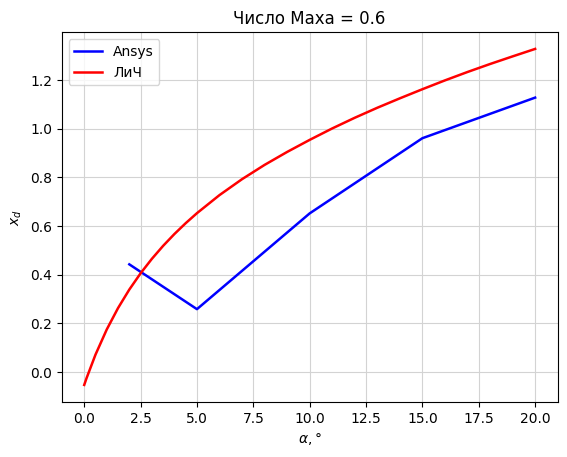

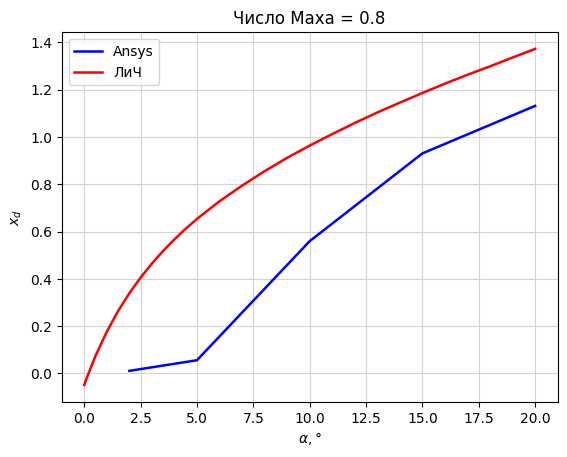

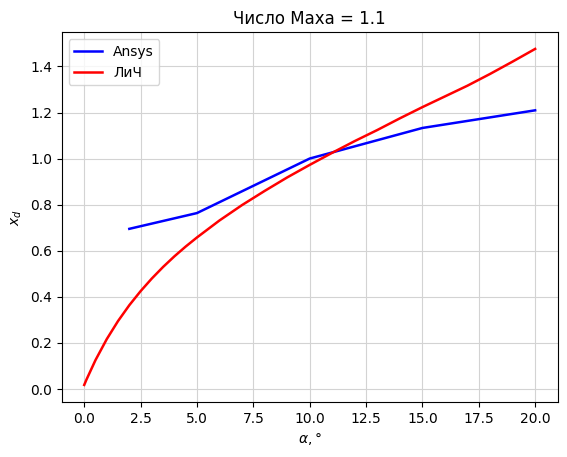

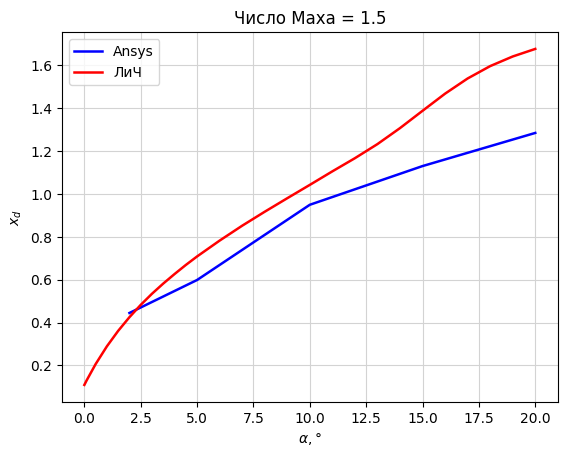

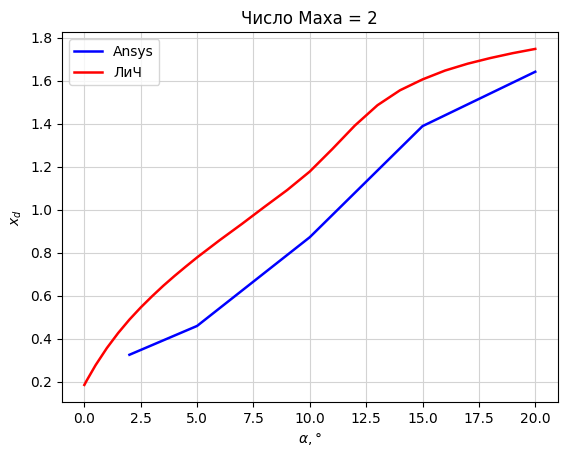

In [13]:
plt.title('Число Маха = 0.6')
plt.plot(alpha_fus_Ansys[1:], Mz_M06_fus_Ansys[1:] / Y_M06_fus_Ansys[1:], color = 'blue', lw = 1.8, label = 'Ansys')
plt.plot(alpha_fus_LiCH, xd_M06_fus_LiH, color = 'red', lw = 1.8, label = 'ЛиЧ')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$x_{d}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('fuselage_plots\M06 x_d.jpeg')
plt.show()

plt.title('Число Маха = 0.8')
plt.plot(alpha_fus_Ansys[1:], Mz_M08_fus_Ansys[1:] / Y_M08_fus_Ansys[1:], color = 'blue', lw = 1.8, label = 'Ansys')
plt.plot(alpha_fus_LiCH, xd_M08_fus_LiH, color = 'red', lw = 1.8, label = 'ЛиЧ')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$x_{d}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('fuselage_plots\M08 x_d.jpeg')
plt.show()

plt.title('Число Маха = 1.1')
plt.plot(alpha_fus_Ansys[1:], Mz_M11_fus_Ansys[1:] / Y_M11_fus_Ansys[1:], color = 'blue', lw = 1.8, label = 'Ansys')
plt.plot(alpha_fus_LiCH, xd_M11_fus_LiH, color = 'red', lw = 1.8, label = 'ЛиЧ')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$x_{d}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('fuselage_plots\M11 x_d.jpeg')
plt.show()

plt.title('Число Маха = 1.5')
plt.plot(alpha_fus_Ansys[1:], Mz_M15_fus_Ansys[1:] / Y_M15_fus_Ansys[1:], color = 'blue', lw = 1.8, label = 'Ansys')
plt.plot(alpha_fus_LiCH, xd_M15_fus_LiH, color = 'red', lw = 1.8, label = 'ЛиЧ')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$x_{d}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('fuselage_plots\M15 x_d.jpeg')
plt.show()

plt.title('Число Маха = 2')
plt.plot(alpha_fus_Ansys[1:], Mz_M2_fus_Ansys[1:] / Y_M2_fus_Ansys[1:], color = 'blue', lw = 1.8, label = 'Ansys')
plt.plot(alpha_fus_LiCH, xd_M2_fus_LiH, color = 'red', lw = 1.8, label = 'ЛиЧ')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$x_{d}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('fuselage_plots\M2 x_d.jpeg')
plt.show()

In [14]:
cy_M06_fus_LiH = []
cy_M11_fus_LiH = []
cy_M15_fus_LiH = []
cy_M2_fus_LiH = []

cx_M06_fus_LiH = []
cx_M11_fus_LiH = []
cx_M15_fus_LiH = []
cx_M2_fus_LiH = []

cya_M06_fus_LiH = []
cya_M11_fus_LiH = []
cya_M15_fus_LiH = []
cya_M2_fus_LiH = []

cxa_M06_fus_LiH = []
cxa_M11_fus_LiH = []
cxa_M15_fus_LiH = []
cxa_M2_fus_LiH = []

mz_M06_fus_LiH = []
mz_M11_fus_LiH = []
mz_M15_fus_LiH = []
mz_M2_fus_LiH = []

xd_M06_fus_LiH = []
xd_M11_fus_LiH = []
xd_M15_fus_LiH = []
xd_M2_fus_LiH = []


alpha_fus = np.array([0, 5, 10, 15, 20])
M_fus = np.linspace(0.6, 2, 400)
H = H_Ansys

for alf in alpha_fus:
    cy_M06_fus_LiH_res = []
    cya_M06_fus_LiH_res = []
    cx_M06_fus_LiH_res = []
    cxa_M06_fus_LiH_res = []
    mz_M06_fus_LiH_res = []
    xd_M06_fus_LiH_res = []

    for M in M_fus:
        c_y = fuselag.c_y(M, np.deg2rad(alf))
        c_ya = fuselag.c_ya(M, np.deg2rad(alf), H, False, x_t = x_t)
        c_x = fuselag.c_x(M, np.deg2rad(alf), H, False, x_t = x_t)
        c_xa = fuselag.c_xa(M, np.deg2rad(alf), H, False, x_t = x_t)        
        xd = fuselag.x_d(M, np.deg2rad(alf))
        cy_M06_fus_LiH_res.append(c_y)
        cya_M06_fus_LiH_res.append(c_ya)
        cx_M06_fus_LiH_res.append(c_x)
        cxa_M06_fus_LiH_res.append(c_xa)        
        xd_M06_fus_LiH_res.append(xd)

    cy_M06_fus_LiH.append(cy_M06_fus_LiH_res)
    cya_M06_fus_LiH.append(cya_M06_fus_LiH_res)
    cx_M06_fus_LiH.append(cx_M06_fus_LiH_res)
    cxa_M06_fus_LiH.append(cxa_M06_fus_LiH_res)    
    xd_M06_fus_LiH.append(xd_M06_fus_LiH_res)

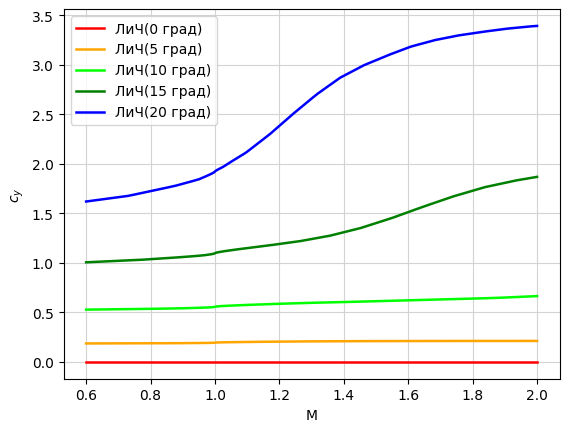

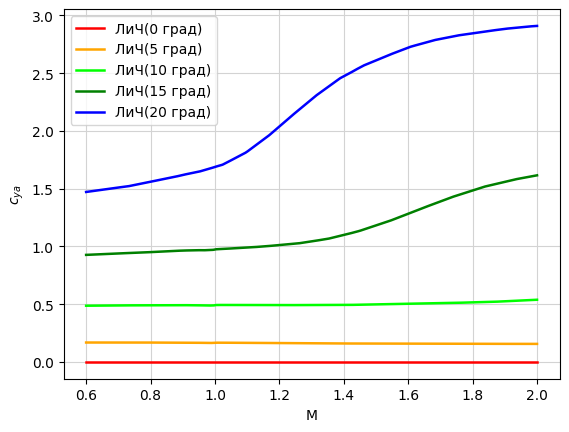

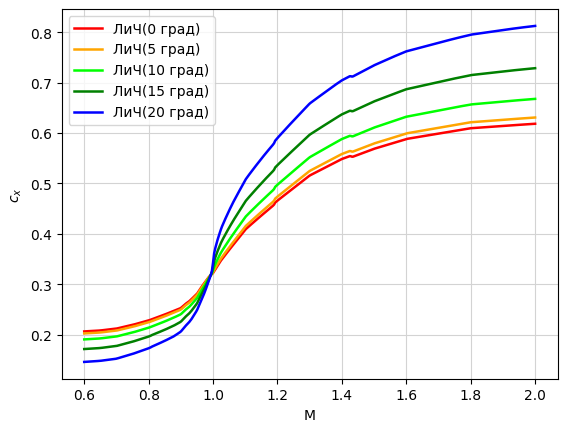

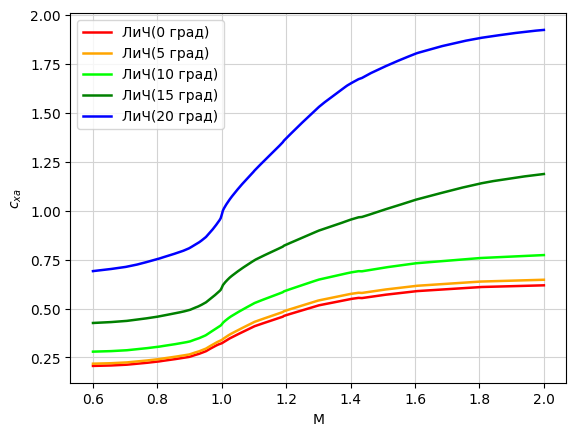

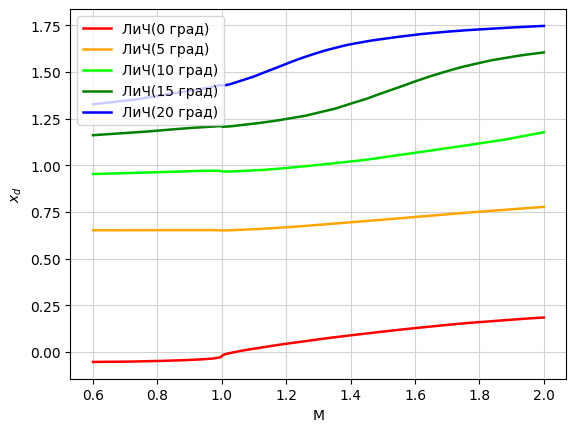

In [15]:
# Нормальная сила
# plt.plot(alpha_fus_Ansys, cy_M06_fus_Ansys, color = 'blue', lw = 1.8, label = 'Ansys')
plt.plot(M_fus, cy_M06_fus_LiH[0], color = 'red', lw = 1.8, label = 'ЛиЧ(0 град)')
plt.plot(M_fus, cy_M06_fus_LiH[1], color = 'orange', lw = 1.8, label = 'ЛиЧ(5 град)')
plt.plot(M_fus, cy_M06_fus_LiH[2], color = 'lime', lw = 1.8, label = 'ЛиЧ(10 град)')
plt.plot(M_fus, cy_M06_fus_LiH[3], color = 'green', lw = 1.8, label = 'ЛиЧ(15 град)')
plt.plot(M_fus, cy_M06_fus_LiH[4], color = 'blue', lw = 1.8, label = 'ЛиЧ(20 град)')
plt.xlabel('M')
plt.ylabel('$c_{y}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('fuselage_plots\c_y.jpeg')
plt.show()

# Подъемная сила
# plt.plot(alpha_fus_Ansys, cya_M06_fus_Ansys, color = 'blue', lw = 1.8, label = 'Ansys')
plt.plot(M_fus, cya_M06_fus_LiH[0], color = 'red', lw = 1.8, label = 'ЛиЧ(0 град)')
plt.plot(M_fus, cya_M06_fus_LiH[1], color = 'orange', lw = 1.8, label = 'ЛиЧ(5 град)')
plt.plot(M_fus, cya_M06_fus_LiH[2], color = 'lime', lw = 1.8, label = 'ЛиЧ(10 град)')
plt.plot(M_fus, cya_M06_fus_LiH[3], color = 'green', lw = 1.8, label = 'ЛиЧ(15 град)')
plt.plot(M_fus, cya_M06_fus_LiH[4], color = 'blue', lw = 1.8, label = 'ЛиЧ(20 град)')
plt.xlabel('M')
plt.ylabel('$c_{ya}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('fuselage_plots\c_ya.jpeg')
plt.show()

# Продольная сила
# plt.plot(alpha_fus_Ansys, cx_M06_fus_Ansys, color = 'blue', lw = 1.8, label = 'Ansys')
plt.plot(M_fus, cx_M06_fus_LiH[0], color = 'red', lw = 1.8, label = 'ЛиЧ(0 град)')
plt.plot(M_fus, cx_M06_fus_LiH[1], color = 'orange', lw = 1.8, label = 'ЛиЧ(5 град)')
plt.plot(M_fus, cx_M06_fus_LiH[2], color = 'lime', lw = 1.8, label = 'ЛиЧ(10 град)')
plt.plot(M_fus, cx_M06_fus_LiH[3], color = 'green', lw = 1.8, label = 'ЛиЧ(15 град)')
plt.plot(M_fus, cx_M06_fus_LiH[4], color = 'blue', lw = 1.8, label = 'ЛиЧ(20 град)')
plt.xlabel('M')
plt.ylabel('$c_{x}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('fuselage_plots\c_x.jpeg')
plt.show()

# Сила лобового сопротивления
# plt.plot(alpha_fus_Ansys, cxa_M06_fus_Ansys, color = 'blue', lw = 1.8, label = 'Ansys')
plt.plot(M_fus, cxa_M06_fus_LiH[0], color = 'red', lw = 1.8, label = 'ЛиЧ(0 град)')
plt.plot(M_fus, cxa_M06_fus_LiH[1], color = 'orange', lw = 1.8, label = 'ЛиЧ(5 град)')
plt.plot(M_fus, cxa_M06_fus_LiH[2], color = 'lime', lw = 1.8, label = 'ЛиЧ(10 град)')
plt.plot(M_fus, cxa_M06_fus_LiH[3], color = 'green', lw = 1.8, label = 'ЛиЧ(15 град)')
plt.plot(M_fus, cxa_M06_fus_LiH[4], color = 'blue', lw = 1.8, label = 'ЛиЧ(20 град)')
plt.xlabel('M')
plt.ylabel('$c_{xa}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('fuselage_plots\c_xa.jpeg')
plt.show()

# Центр давления
# plt.plot(alpha_fus_Ansys[1:], b_b/2 + Mz_M06_fus_Ansys[1:]/Y_M06_fus_Ansys[1:], color = 'blue', lw = 1.8, label = 'Ansys')
plt.plot(M_fus, xd_M06_fus_LiH[0], color = 'red', lw = 1.8, label = 'ЛиЧ(0 град)')
plt.plot(M_fus, xd_M06_fus_LiH[1], color = 'orange', lw = 1.8, label = 'ЛиЧ(5 град)')
plt.plot(M_fus, xd_M06_fus_LiH[2], color = 'lime', lw = 1.8, label = 'ЛиЧ(10 град)')
plt.plot(M_fus, xd_M06_fus_LiH[3], color = 'green', lw = 1.8, label = 'ЛиЧ(15 град)')
plt.plot(M_fus, xd_M06_fus_LiH[4], color = 'blue', lw = 1.8, label = 'ЛиЧ(20 град)')
plt.xlabel('M')
plt.ylabel('$x_{d}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('fuselage_plots\\x_d.jpeg')
plt.show()

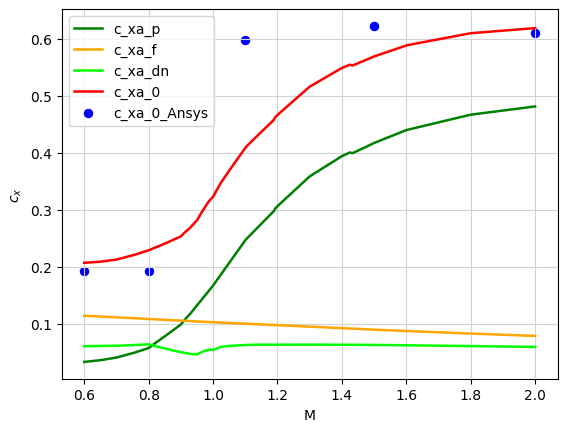

In [16]:
c_xa_p_res = []
c_xa_f_res = []
c_xa_dn_res = []
c_xa_0_res = []

M_fus = np.linspace(0.6, 2, 400)
H = H_Ansys

M_ansys = np.array([0.6, 0.8, 1.1, 1.5, 2])
c_xa_0_ansys = np.array([cxa_M06_fus_Ansys[0], cxa_M06_fus_Ansys[0], cxa_M11_fus_Ansys[0], cxa_M15_fus_Ansys[0], cxa_M2_fus_Ansys[0]])

for M in M_fus:
    c_xa_p = fuselag.c_xa0_p(M, H)
    c_xa_f = fuselag.c_xa0_f(M, H, x_t, T_s)
    c_xa_dn = fuselag.c_xa_dn(M, H, is_active, x_t, T_s)
    c_xa_0 = fuselag.c_xa(M, 0, H, is_active, x_t, T_s)
    
    c_xa_p_res.append(c_xa_p)
    c_xa_f_res.append(c_xa_f)
    c_xa_dn_res.append(c_xa_dn)
    c_xa_0_res.append(c_xa_0)

    
plt.plot(M_fus, c_xa_p_res, color = 'green', lw = 1.8, label = 'c_xa_p')
plt.plot(M_fus, c_xa_f_res, color = 'orange', lw = 1.8, label = 'c_xa_f')
plt.plot(M_fus, c_xa_dn_res, color = 'lime', lw = 1.8, label = 'c_xa_dn')
plt.plot(M_fus, c_xa_0_res, color = 'red', lw = 1.8, label = 'c_xa_0')
plt.scatter(M_ansys, c_xa_0_ansys, color = 'blue', lw = 0.8, label = 'c_xa_0_Ansys')

plt.xlabel('M')
plt.ylabel('$c_{x}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('fuselage_plots\c_x_components.jpeg', facecolor='white')
plt.show()

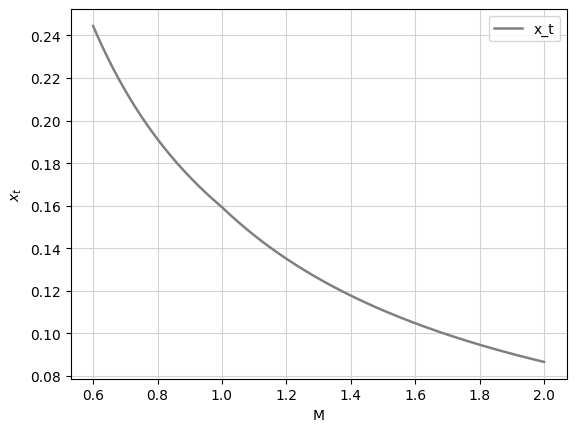

In [17]:
x_t_res = []

M_fus = np.linspace(0.6, 2, 400)
H = H_Ansys

for M in M_fus:    
    x_t_ = fuselag.x_t(M, H, T_s)    
   
    x_t_res.append(x_t_)

plt.plot(M_fus, x_t_res, color = 'gray', lw = 1.8, label = 'x_t')

plt.xlabel('M')
plt.ylabel('$x_{t}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('fuselage_plots\\x_t.jpeg', facecolor='white')
plt.show()

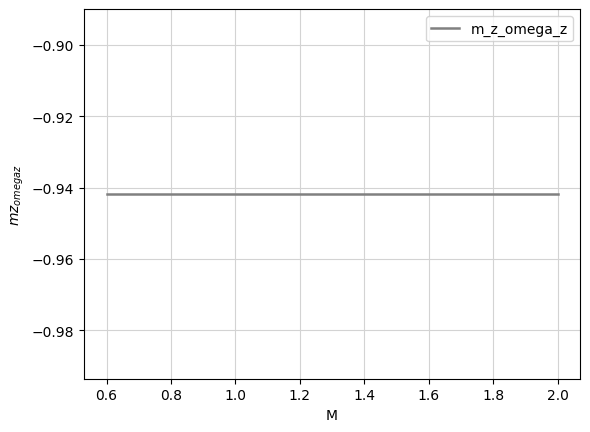

In [19]:
m_z_omega_z_res = []

M_fus = np.linspace(0.6, 2, 400)
H = H_Ansys

for M in M_fus:    
    m_z_omega_z_ = fuselag.m_z_omega_z(M, 0)   
    
    m_z_omega_z_res.append(m_z_omega_z_)


plt.plot(M_fus, m_z_omega_z_res, color = 'gray', lw = 1.8, label = 'm_z_omega_z')

plt.xlabel('M')
plt.ylabel('$mz_{omegaz}$')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.savefig('fuselage_plots\\m_z_omega_z.jpeg', facecolor='white')
plt.show()